## Dependencies

In [1]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

## Importing and Prepping Schedules

In [2]:
schedules_df = nfl.import_schedules([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [3]:
def calculate_implied_totals(df):
    """
    Calculate the implied home and away team totals based on the spread and total lines.
    """
    # Implied totals based on the total and spread lines
    df['implied_home_total'] = (df['total_line'] + df['spread_line']) / 2
    df['implied_away_total'] = (df['total_line'] - df['spread_line']) / 2
    
    return df

In [4]:
schedules_df = calculate_implied_totals(schedules_df)
# explore this if we can prove lines are out before upcoming week

In [5]:
schedules_df.drop(columns= ['away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium', 'away_score', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game',
       'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'gameday', 'weekday',
       'gametime'], inplace=True)

In [66]:
# Create a DataFrame for away quarterbacks
away_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'away_qb_name', 'implied_away_total']].copy()
away_df.rename(columns={'away_team': 'team', 'away_qb_name': 'qb_name', 'implied_away_total': 'implied_total'}, inplace=True)
away_df['home_away'] = 'away'

# Create a DataFrame for home quarterbacks
home_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'home_team', 'away_team', 'home_qb_name', 'implied_home_total']].copy()
home_df.rename(columns={'home_team': 'team', 'home_qb_name': 'qb_name', 'implied_home_total': 'implied_total'}, inplace=True)
home_df['home_away'] = 'home'

# Concatenate both DataFrames
combined_schedule_df = pd.concat([away_df, home_df])

# Reset index for cleanliness
combined_schedule_df.reset_index(drop=True, inplace=True)

In [67]:
# Assuming your DataFrame is named df
combined_schedule_df.rename(columns={'team': 'posteam'}, inplace=True)

In [98]:
combined_schedule_df

,game_id,season,game_type,week,posteam,home_team,qb_name,implied_total,home_away,away_team,player_passer_name
0,2014_01_GB_SEA,2014,REG,1,GB,SEA,Aaron Rodgers,21.00,away,NaN,A.Rodgers
1,2014_01_NO_ATL,2014,REG,1,NO,ATL,Drew Brees,27.00,away,NaN,D.Brees
2,2014_01_CIN_BAL,2014,REG,1,CIN,BAL,Andy Dalton,21.25,away,NaN,A.Dalton
3,2014_01_BUF_CHI,2014,REG,1,BUF,CHI,EJ Manuel,20.00,away,NaN,E.Manuel
4,2014_01_WAS_HOU,2014,REG,1,WAS,HOU,Robert Griffin,20.25,away,NaN,R.Griffin
...,...,...,...,...,...,...,...,...,...,...,...
5989,2024_18_MIA_NYJ,2024,REG,18,NYJ,NaN,NaN,NaN,home,MIA,
5990,2024_18_NYG_PHI,2024,REG,18,PHI,NaN,NaN,NaN,home,NYG,
5991,2024_18_CIN_PIT,2024,REG,18,PIT,NaN,NaN,NaN,home,CIN,
5992,2024_18_NO_TB,2024,REG,18,TB,NaN,NaN,NaN,home,NO,


In [68]:
# Function to format QB names into the desired "A.Dalton" format, handling missing values
def format_passer_name(qb_name):
    if pd.isna(qb_name):  # Check if the name is NaN
        return ""
    
    name_parts = qb_name.split()
    
    # Extract the first name and last name
    first_name = name_parts[0]
    last_name = name_parts[-1]  # Last name should always be the last part
    
    return f"{first_name[0]}.{last_name}"

# Apply the function to create the new 'player_passer_name' column
combined_schedule_df['player_passer_name'] = combined_schedule_df['qb_name'].apply(format_passer_name)

## Importing PBP Training Data

In [9]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2024 + 1), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer DF Prep

In [10]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Reorder the columns
passer_df = passer_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass' ,'game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

## Defense DF Prep

In [11]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Reorder the columns
defense_df = defense_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

## Preprocessing

In [12]:
def calculate_offensive_ewma(passer_df):
    """
    Calculates EWMA for offensive columns using previous weeks' data, ensuring no leakage by excluding the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, excluding the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return passer_df

In [13]:
def pass_cleaner(passer_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    passer_df.drop(columns=['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe', 'home_team', 'away_team', 
                                    'complete_pass', 'incomplete_pass'], inplace=True)
    
    return passer_df

In [14]:
passer_emwa = calculate_offensive_ewma(passer_df)

In [15]:
passer_prepped = pass_cleaner(passer_emwa)

In [16]:
def calculate_defensive_ewma(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return defense_df

In [17]:
def def_cleaner(defense_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    # Drop the non-ewma columns
    defense_df.drop(columns=['passing_yards','completion_percentage',
                            'air_yards', 'yards_after_catch', 'epa',     
                            'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe', 'complete_pass', 'incomplete_pass',
                            'home_team', 'away_team'
                            ], inplace=True)
    
    return defense_df

In [18]:
defense_ewma = calculate_defensive_ewma(defense_df)

In [19]:
defense_prepped = def_cleaner(defense_ewma)

In [20]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_prepped.merge(defense_prepped, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# Get rid of flukey rows
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8) & (full_with_ewma['passing_yards'] >= 10)]

#Ford Field is empty, you hate to see that
filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_22952\3866188713.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)


## Week 1 is NaN's (duh, we use past weeks for EWMA's) for MVP I'll just get rid but for future seasons/rookies I do need a strategy

In [21]:
filtered_with_ewma = filtered_with_ewma.dropna()

In [22]:
# Perform the merge based on game_id, season, week, and team
filtered_with_ewma_it = pd.merge(filtered_with_ewma, combined_schedule_df[['game_id', 'season', 'week', 'posteam', 'implied_total']], 
                     on=['game_id', 'season', 'week', 'posteam'], 
                     how='inner')

In [23]:
filtered_with_ewma_it.isna().sum()

game_id                               0
passer_player_name                    0
posteam                               0
defteam                               0
season                                0
week                                  0
passing_yards                         0
home_flag_passer                      0
pass_attempts                         0
roof                                  0
surface                               0
completion_percentage_ewma_passer     0
pass_attempts_ewma_passer             0
air_yards_ewma_passer                 0
yards_after_catch_ewma_passer         0
epa_ewma_passer                       0
interception_ewma_passer              0
qb_hit_ewma_passer                    0
sack_ewma_passer                      0
pass_touchdown_ewma_passer            0
passing_yards_ewma_passer             0
cpoe_ewma_passer                      0
home_flag_defense                     0
completion_percentage_ewma_defense    0
pass_attempts_ewma_defense            0


## Modeling

In [24]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma_it.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

# Define categorical and numeric columns
categorical_columns = ['roof', 'surface']
numeric_columns = [col for col in features if col not in categorical_columns]

# Split the data into training (up to 2023) and testing (2024)
train_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] <= 2023]
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

# Separate features and target for both training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed data into a LightGBM-compatible format
train_data_lgb = lgb.Dataset(X_train_transformed, label=y_train)
test_data_lgb = lgb.Dataset(X_test_transformed, label=y_test, reference=train_data_lgb)

# Set up the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 20,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': -1,
    'bagging_freq': 1
}

# Train the model with early stopping
lgb_model = lgb.train(params, train_data_lgb, valid_sets=[test_data_lgb], callbacks=[lgb.early_stopping(stopping_rounds=10)], num_boost_round=1000)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test_transformed, num_iteration=lgb_model.best_iteration)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 74.7118
RMSE: 74.71181714699182


In [25]:
features

Index(['home_flag_passer', 'roof', 'surface',
       'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer',
       'air_yards_ewma_passer', 'yards_after_catch_ewma_passer',
       'epa_ewma_passer', 'interception_ewma_passer', 'qb_hit_ewma_passer',
       'sack_ewma_passer', 'pass_touchdown_ewma_passer',
       'passing_yards_ewma_passer', 'cpoe_ewma_passer', 'home_flag_defense',
       'completion_percentage_ewma_defense', 'pass_attempts_ewma_defense',
       'air_yards_ewma_defense', 'yards_after_catch_ewma_defense',
       'epa_ewma_defense', 'interception_ewma_defense', 'qb_hit_ewma_defense',
       'sack_ewma_defense', 'pass_touchdown_ewma_defense',
       'passing_yards_ewma_defense', 'cpoe_ewma_defense', 'implied_total'],
      dtype='object')

In [26]:
# Ensure test_data contains the 2024 season
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

In [27]:
# Add predictions to the test_data (2024) DataFrame
test_data['predicted_passing_yards'] = y_pred

# Calculate whether the model over-predicted or under-predicted
test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']

# # Display the updated dataframe with actual, predicted, and over/under information
# test_data[['week', 'passer_player_name', 'passing_yards', 'predicted_passing_yards', 'pyoe']].sort_values(by='predicted_passing_yards', key=abs, ascending=False).tail(60)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_22952\2626295089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_passing_yards'] = y_pred
C:\Users\bhugg\AppData\Local\Temp\ipykernel_22952\2626295089.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']


## Current Week Preprocessing

In [28]:
def calculate_ewma_tester_off(passer_df):
    """
    Calculates EWMA for offensive columns using the current and previous weeks' data, including the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, including the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return passer_df

In [72]:
passer_df_tester = passer_df[(passer_df['season'] == 2024)]

In [73]:
prediction_set_passer_nc = calculate_ewma_tester_off(passer_df_tester)

In [74]:
prediction_set_passer = pass_cleaner(prediction_set_passer_nc)

In [32]:
def calculate_ewma_tester_def(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return defense_df

In [69]:
defense_df_tester = defense_df[defense_df['season'] == 2024]

In [70]:
prediction_set_defense_nc = calculate_ewma_tester_def(defense_df_tester)

In [71]:
prediction_set_defense = def_cleaner(prediction_set_defense_nc)

In [89]:
# Merge the defense and passer dataframes together
prediction_set = prediction_set_passer.merge(prediction_set_defense, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# Get rid of flukey rows
filtered_prediction_set = prediction_set[(prediction_set['pass_attempts'] > 8) & (prediction_set['passing_yards'] >= 10)]

#Ford Field is empty, you hate to see that
filtered_prediction_set['surface'].replace('', 'fieldturf', inplace=True)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_22952\1495436634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_prediction_set['surface'].replace('', 'fieldturf', inplace=True)


In [90]:
filtered_prediction_set = filtered_prediction_set[filtered_prediction_set['week'] ==  5]

In [91]:
filtered_prediction_set

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
5,2024_05_CAR_CHI,A.Dalton,CAR,CHI,2024,5,136.0,False,27.0,outdoors,grass,0.646933,29.800000,225.675000,72.825000,-11.152178,0.900000,5.475000,2.175000,0.675000,165.225000,-2.434265,True,0.654938,31.487603,249.347107,79.925620,-14.279837,1.057851,7.099174,3.520661,0.033058,199.768595,-1.082575
8,2024_05_IND_JAX,J.Flacco,IND,JAX,2024,5,359.0,False,44.0,outdoors,grass,0.716346,39.500000,329.750000,113.750000,9.743142,0.000000,5.250000,3.500000,2.750000,311.250000,7.636640,True,0.735170,42.504132,321.446281,159.495868,13.451544,0.000000,4.991736,3.198347,2.760331,360.561983,6.988943
11,2024_05_LV_DEN,A.O'Connell,LV,DEN,2024,5,94.0,False,19.0,outdoors,grass,0.582237,17.250000,161.250000,30.500000,-2.619170,0.750000,3.500000,1.000000,0.250000,91.000000,-6.053392,True,0.641088,35.206612,293.123967,115.719008,-15.556525,2.090909,7.793388,3.710744,0.776860,221.280992,-3.193004
12,2024_05_LV_DEN,G.Minshew,LV,DEN,2024,5,137.0,False,15.0,outdoors,grass,0.741849,18.586777,155.297521,91.958678,-8.165035,1.446281,2.793388,2.090909,0.776860,145.603306,-0.123977,True,0.641088,35.206612,293.123967,115.719008,-15.556525,2.090909,7.793388,3.710744,0.776860,221.280992,-3.193004
23,2024_05_NYJ_MIN,A.Rodgers,NYJ,MIN,2024,5,244.0,False,51.0,outdoors,grass,0.585787,47.024793,365.049587,118.214876,-12.770483,2.016529,10.661157,3.330579,1.545455,240.190083,-6.285805,True,0.595838,49.768595,431.652893,132.066116,-13.544932,2.867769,10.462810,2.793388,2.330579,282.421488,-5.896185
30,2024_05_TB_ATL,B.Mayfield,TB,ATL,2024,5,180.0,False,24.0,closed,fieldturf,0.753639,29.628099,162.314050,130.371901,6.738869,0.099174,1.942149,1.768595,2.586777,217.024793,3.049693,True,0.785135,27.611570,145.033058,112.239669,6.473052,0.322314,2.016529,0.933884,2.181818,195.793388,5.745237
35,2024_05_LV_DEN,B.Nix,DEN,LV,2024,5,206.0,True,26.0,outdoors,grass,0.668351,26.809917,181.537190,117.016529,-2.081967,0.066116,3.512397,2.074380,1.561983,174.595041,-1.482547,False,0.736413,28.057851,159.057851,138.462810,1.031300,0.247934,5.297521,2.884298,1.818182,208.214876,2.320598
41,2024_05_ARI_SF,B.Purdy,SF,ARI,2024,5,244.0,True,33.0,outdoors,grass,0.593954,31.231405,321.074380,95.099174,2.084596,1.586777,4.661157,1.801653,1.140496,259.140496,-0.411280,False,0.670253,31.057851,258.950413,105.809917,2.795163,1.636364,3.966942,1.628099,1.057851,237.404959,2.237395
52,2024_05_BUF_HOU,C.Stroud,HOU,BUF,2024,5,331.0,True,37.0,closed,astroturf,0.732376,36.933884,257.305785,170.016529,6.806071,0.818182,5.975207,1.520661,1.231405,322.933884,3.953158,False,0.736800,33.504132,220.479339,151.743802,3.542846,0.818182,5.595041,1.347107,1.223140,278.404959,6.355760
57,2024_05_CAR_CHI,C.Williams,CHI,CAR,2024,5,304.0,True,29.0,outdoors,grass,0.696975,29.297521,220.297521,156.942149,8.753779,0.198347,2.661157,1.826446,1.710744,270.619835,4.207281,False,0.701612,29.677686,206.115702,166.611570,11.668436,0.322314,2.289256,0.925620,2.008264,282.165289,2.782019


In [92]:
# filtered_prediction_set['week'] = filtered_prediction_set['week'] + 1

In [93]:
filtered_prediction_set.columns

Index(['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week',
       'passing_yards', 'home_flag_passer', 'pass_attempts', 'roof', 'surface',
       'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer',
       'air_yards_ewma_passer', 'yards_after_catch_ewma_passer',
       'epa_ewma_passer', 'interception_ewma_passer', 'qb_hit_ewma_passer',
       'sack_ewma_passer', 'pass_touchdown_ewma_passer',
       'passing_yards_ewma_passer', 'cpoe_ewma_passer', 'home_flag_defense',
       'completion_percentage_ewma_defense', 'pass_attempts_ewma_defense',
       'air_yards_ewma_defense', 'yards_after_catch_ewma_defense',
       'epa_ewma_defense', 'interception_ewma_defense', 'qb_hit_ewma_defense',
       'sack_ewma_defense', 'pass_touchdown_ewma_defense',
       'passing_yards_ewma_defense', 'cpoe_ewma_defense'],
      dtype='object')

In [94]:
filtered_prediction_set.drop(columns = ['game_id', 'passing_yards', 'pass_attempts'], inplace=True)

In [95]:
defense_columns = [
    'season', 'week', 'roof', 'surface', 'defteam', 'posteam', 'home_flag_defense', 'completion_percentage_ewma_defense', 'pass_attempts_ewma_defense',
    'air_yards_ewma_defense', 'yards_after_catch_ewma_defense', 'epa_ewma_defense',
    'interception_ewma_defense', 'qb_hit_ewma_defense', 'sack_ewma_defense',
    'pass_touchdown_ewma_defense', 'passing_yards_ewma_defense', 'cpoe_ewma_defense'
]

defense_df_tbj = filtered_prediction_set[defense_columns]

In [97]:
defense_df_tbj

,season,week,roof,surface,defteam,posteam,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
5,2024,5,outdoors,grass,CHI,CAR,True,0.654938,31.487603,249.347107,79.925620,-14.279837,1.057851,7.099174,3.520661,0.033058,199.768595,-1.082575
8,2024,5,outdoors,grass,JAX,IND,True,0.735170,42.504132,321.446281,159.495868,13.451544,0.000000,4.991736,3.198347,2.760331,360.561983,6.988943
11,2024,5,outdoors,grass,DEN,LV,True,0.641088,35.206612,293.123967,115.719008,-15.556525,2.090909,7.793388,3.710744,0.776860,221.280992,-3.193004
12,2024,5,outdoors,grass,DEN,LV,True,0.641088,35.206612,293.123967,115.719008,-15.556525,2.090909,7.793388,3.710744,0.776860,221.280992,-3.193004
23,2024,5,outdoors,grass,MIN,NYJ,True,0.595838,49.768595,431.652893,132.066116,-13.544932,2.867769,10.462810,2.793388,2.330579,282.421488,-5.896185
30,2024,5,closed,fieldturf,ATL,TB,True,0.785135,27.611570,145.033058,112.239669,6.473052,0.322314,2.016529,0.933884,2.181818,195.793388,5.745237
35,2024,5,outdoors,grass,LV,DEN,False,0.736413,28.057851,159.057851,138.462810,1.031300,0.247934,5.297521,2.884298,1.818182,208.214876,2.320598
41,2024,5,outdoors,grass,ARI,SF,False,0.670253,31.057851,258.950413,105.809917,2.795163,1.636364,3.966942,1.628099,1.057851,237.404959,2.237395
52,2024,5,closed,astroturf,BUF,HOU,False,0.736800,33.504132,220.479339,151.743802,3.542846,0.818182,5.595041,1.347107,1.223140,278.404959,6.355760
57,2024,5,outdoors,grass,CAR,CHI,False,0.701612,29.677686,206.115702,166.611570,11.668436,0.322314,2.289256,0.925620,2.008264,282.165289,2.782019


In [96]:
offense_columns = [
    'season', 'week', 'roof', 'surface', 'posteam', 'defteam', 'passer_player_name', 'season', 'week', 'roof', 'surface',
    'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer', 'air_yards_ewma_passer',
    'yards_after_catch_ewma_passer', 'epa_ewma_passer', 'interception_ewma_passer',
    'qb_hit_ewma_passer', 'sack_ewma_passer', 'pass_touchdown_ewma_passer',
    'passing_yards_ewma_passer', 'cpoe_ewma_passer'
]

offense_df_tbj = filtered_prediction_set[offense_columns]

In [59]:
combined_schedule_preds = combined_schedule_df[combined_schedule_df['season'] == combined_schedule_df['season'].max()]
combined_schedule_preds[combined_schedule_preds['week'] == 6]

,game_id,season,game_type,week,posteam,qb_name,implied_total,home_away,player_passer_name
2803,2024_06_SF_SEA,2024,REG,6,SF,Brock Purdy,26.25,away,B.Purdy
2804,2024_06_JAX_CHI,2024,REG,6,JAX,Trevor Lawrence,23.00,away,T.Lawrence
2805,2024_06_WAS_BAL,2024,REG,6,WAS,Jayden Daniels,22.50,away,J.Daniels
2806,2024_06_ARI_GB,2024,REG,6,ARI,Kyler Murray,20.75,away,K.Murray
2807,2024_06_HOU_NE,2024,REG,6,HOU,C.J. Stroud,22.50,away,C.Stroud
2808,2024_06_TB_NO,2024,REG,6,TB,Baker Mayfield,23.00,away,B.Mayfield
2809,2024_06_CLE_PHI,2024,REG,6,CLE,Deshaun Watson,17.00,away,D.Watson
2810,2024_06_IND_TEN,2024,REG,6,IND,Joe Flacco,19.75,away,J.Flacco
2811,2024_06_LAC_DEN,2024,REG,6,LAC,Justin Herbert,19.25,away,J.Herbert
2812,2024_06_PIT_LV,2024,REG,6,PIT,Russell Wilson,20.00,away,R.Wilson


In [ ]:
defense_columns = [
    'season', 'week', 'roof', 'surface'defteam', 'posteam', 'home_flag_defense', 'completion_percentage_ewma_defense', 'pass_attempts_ewma_defense',
    'air_yards_ewma_defense', 'yards_after_catch_ewma_defense', 'epa_ewma_defense',
    'interception_ewma_defense', 'qb_hit_ewma_defense', 'sack_ewma_defense',
    'pass_touchdown_ewma_defense', 'passing_yards_ewma_defense', 'cpoe_ewma_defense'
]

defense_df = passer_df[defense_columns]

In [ ]:
offense_columns = [
    'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'roof', 'surface',
    'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer', 'air_yards_ewma_passer',
    'yards_after_catch_ewma_passer', 'epa_ewma_passer', 'interception_ewma_passer',
    'qb_hit_ewma_passer', 'sack_ewma_passer', 'pass_touchdown_ewma_passer',
    'passing_yards_ewma_passer', 'cpoe_ewma_passer'
]

offense_df = passer_df[offense_columns]

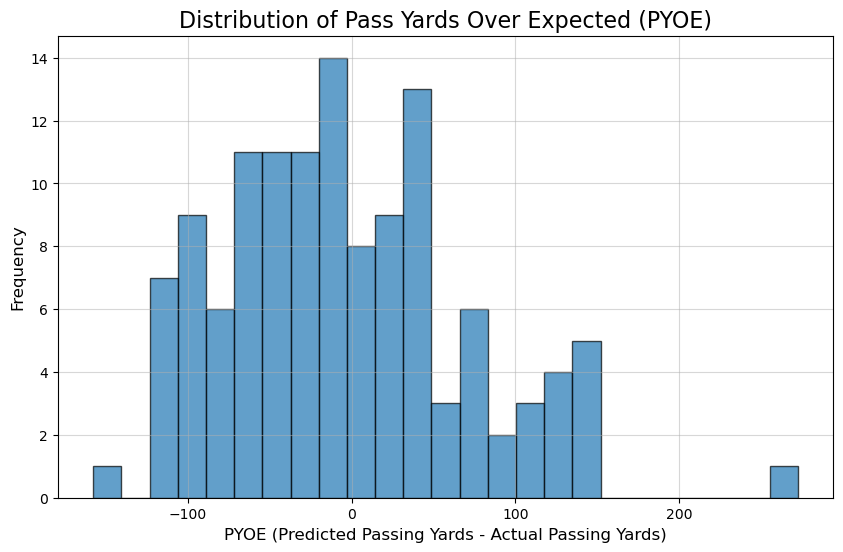

In [63]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['pyoe'], bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards Over Expected (PYOE)', fontsize=16)
plt.xlabel('PYOE (Predicted Passing Yards - Actual Passing Yards)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

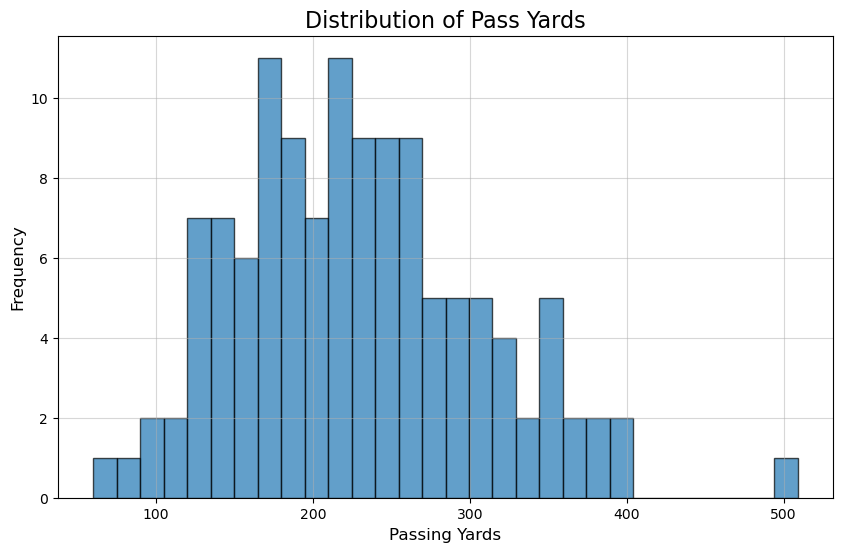

In [64]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['passing_yards'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

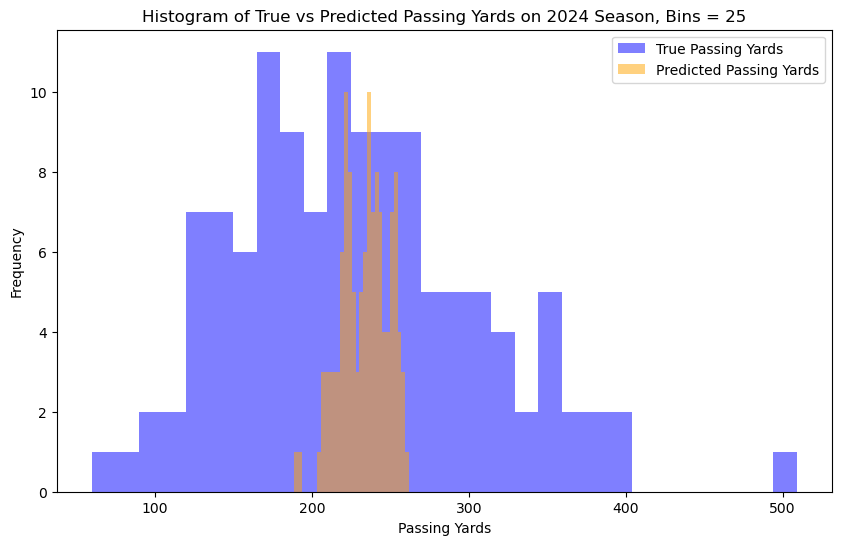

In [65]:
# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(test_data['passing_yards'], bins=30, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(test_data['predicted_passing_yards'], bins=30, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()